# Churn Detection

The objective of this project is to work with a customer dataset from a TV and
broadband telecommunications company. In this area, "churn" refers to the situation
where customers cancel their subscription to the company's services, leading to a loss
of revenue. The company would like to use their existing customer data to build a
model to predict future churn.

In [2]:
#Importing useful libraries
import csv, urllib.request, numpy as np, pandas as pd
from pathlib import Path
import matplotlib, matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Task 1: Data Characterisation and Preprocessing

In [ ]:
url = "http://mlg.ucd.ie/modules/COMP30760/assignment2/21334466.csv"

In [491]:
#Loading dataset into a pandas DataFrame
df = pd.read_csv(url, index_col="customer_id")

First, let's take a look at our dataframe:

In [5]:
df.head(10)

,age,location,gender,credit_score,membership_length,balance,payment_method,num_products,has_broadband,has_tv,broadband_bundle,tv_bundle,num_support_calls,churn
customer_id,,,,,,,,,,,,,,
71167,38.0,Leinster,Female,577,24,668.02,CreditCard,1,True,False,2GB,NaN,2,0
38777,27.0,Munster,Female,698,52,531.28,CreditCard,1,False,True,NaN,Basic,0,0
76011,35.0,Connacht,Male,739,25,0.00,DirectDebit,1,True,False,2GB,NaN,1,0
62859,38.0,Leinster,Male,628,39,530.97,DirectDebit,1,True,False,2GB,NaN,0,0
53782,29.0,Munster,female,557,49,561.10,DirectDebit,2,True,True,500Mbps,Basic,1,0
88770,31.0,Leinster,Male,570,86,0.00,DirectDebit,1,True,False,2GB,NaN,1,0
86120,37.0,Leinster,Female,851,23,0.00,DirectDebit,2,True,True,1GB,Basic,4,0
58270,28.0,Ulster,Male,684,24,0.00,DirectDebit,2,True,True,1GB,Basic,0,0
64696,42.0,Leinster,Female,550,93,262.75,DirectDebit,1,True,False,2GB,NaN,0,0


In [6]:
df.shape

(1508, 14)

We have 1508 rows and 14 columns in our dataset.

### Performing initial characterisation of dataset to identify data quality issues


Possible Quality Issues:

- Missing values - Filter out or fill in missing data.

- Duplicate rows - Filter out identical rows as they do not provide any extra information, and should not be counted because some values must be unique (e.g. customer_id)

- Erroneous/irregular values - Inconsistent representation of an attribute value (e.g. female, Female, F.) Normalising the data will ensure the data is consistent (and not redundant.)

- Continuous values - Convert continuous numerical values into discrete intervals (binning). This will make the data easier to work with, and allow us to identify patterns within specific ranges of values. (Could do this with the features: age, credit score, membership length, balance)

### Data Quality Issues
#### Missing values

In [7]:
df.isna().sum()

age                   18
location               0
gender                 0
credit_score           0
membership_length      0
balance                0
payment_method        26
num_products           0
has_broadband          0
has_tv                 0
broadband_bundle     400
tv_bundle            494
num_support_calls      0
churn                  0
dtype: int64

#### Data Quality Issue
There are missing age and payment method values. 

A large portion of the dataset is also missing broadband_bundle or tv_bundle values, but we know that this is intentional since some customers don't have broadband or tv. 

Both of these issues will be dealt with later on.

#### Duplicate rows

In [8]:
#Check number of duplicated rows
df.duplicated().sum()

0

No duplicated rows. No action required.

#### Check for irregular values

First, I will check the set of different values for different attributes to see if there are any irregular values. I will only look at the categorical data here. 

Categorical Columns: 
- gender
- location
- payment_method 
- has_broadband 
- has_tv
- broadband_bundle
- tv_bundle

In [9]:
df["gender"].value_counts()

Male      672
Female    612
female     90
male       59
F          42
M          33
Name: gender, dtype: int64

In [10]:
df["location"].value_counts()

Leinster    538
Munster     495
Connacht    329
Ulster      146
Name: location, dtype: int64

In [11]:
df["payment_method"].value_counts()

DirectDebit    1015
CreditCard      405
CC               40
DD               22
Name: payment_method, dtype: int64

In [12]:
df["has_broadband"].value_counts()

True     1108
False     400
Name: has_broadband, dtype: int64

In [13]:
df["has_tv"].value_counts()

True     1014
False     494
Name: has_tv, dtype: int64

In [14]:
df["broadband_bundle"].value_counts()

1GB        389
2GB        366
500Mbps    353
Name: broadband_bundle, dtype: int64

In [15]:
df["tv_bundle"].value_counts()

Premium    547
Basic      467
Name: tv_bundle, dtype: int64

##### Data Quality Issue
We can see that two attributes have irregular values.

1) gender:
    - Male is also represented as male and M
    - Female is also represented as female and F
    
    
2) payment_method:

    - DirectDebit is also represented as DD
    
    - CreditCard is also represented as CC
    
The rest of the attributes seem to have unique value representations.

### Binning data

Here I will take a look at continuous data, which is strictly numeric.

Numeric Columns:
- age
- credit_score
- membership_length
- balance
- num_products
- num_support_calls
- churn

In [16]:
df["age"].value_counts()

33.0    81
32.0    75
37.0    67
35.0    57
34.0    56
        ..
77.0     1
69.0     1
79.0     1
72.0     1
84.0     1
Name: age, Length: 62, dtype: int64

In [17]:
df["age"].min()

18.0

In [18]:
df["age"].max()

84.0

The range of ages is 18-84, which is a valid range of age values.

In [19]:
df["credit_score"].value_counts()

599    14
618    10
668    10
698    10
643    10
       ..
830     1
568     1
857     1
689     1
431     1
Name: credit_score, Length: 435, dtype: int64

In [20]:
df["credit_score"].min()

300

In [21]:
df["credit_score"].max()

890

The range of credit scores is normal here too.

In [22]:
df["membership_length"].value_counts()

1      189
13      84
12      79
25      47
23      43
      ... 
122      1
130      1
124      1
126      1
125      1
Name: membership_length, Length: 92, dtype: int64

In [23]:
df["membership_length"].min()

1

In [24]:
df["membership_length"].max()

130

The range of membership length is normal, as all values are positive and valid.

In [25]:
df["balance"].value_counts()

 0.00      496
-1.00       14
 571.50      2
 537.16      2
 419.89      2
          ... 
 684.26      1
 591.80      1
 387.71      1
 392.89      1
 673.96      1
Name: balance, Length: 988, dtype: int64

In [26]:
df["balance"].min()

-1.0

In [27]:
df["balance"].max()

1445.2625

Balance should not be negative.

In [28]:
df["num_products"].value_counts()

1    894
2    544
3     54
4     16
Name: num_products, dtype: int64

We can see the entire range of products here since there are only 4 values. 

All looks normal.

In [29]:
df["num_support_calls"].value_counts()

 0     715
 1     296
 2     166
 3      81
 4      66
 5      50
 7      45
 6      44
 8      23
 9      12
 10      8
-1       2
Name: num_support_calls, dtype: int64

We can see the range of support calls here as well. 

-1 is not a valid value.

In [30]:
df["churn"].value_counts()

0    905
1    603
Name: churn, dtype: int64

#### Data Quality Issue

The fields age, credit_score, membership_length, balance have over 50 different possible values, with some attributes in the 100s of values. 

These are too many values to look at individually, so I would like to bin these fields over a discrete number of intervals.
    
#### Data Quality Issue
There are negative values in some fields. Notably, -1 in the balance and the number of support calls. 

These values should not be negative, so there are some errors here.

## Apply data preprocessing steps to address all identified data quality issues

We will look at all the issues above and solve them.

### Fixing Issue - Missing Values

We know from the previous section that some age and payment method values are missing.

I would like to check the percentage of customers with such unknown values. 

If the number is very low, we can delete those customer entries from our dataset, since they would not affect the data analysis.

In [492]:
rows = df.shape[0]
print("Percentage of customers with unknown age: %.3f %%" % ((df["age"].isna().sum()) / rows))

Percentage of customers with unknown age: 0.012 %


In [493]:
# We can also do the same for payment method
print("Percentage of customers with unknown payment method: %.3f %%" % ((df["payment_method"].isna().sum()) / rows))

Percentage of customers with unknown payment method: 0.017 %


This is a very small percentage of our dataset, about 0.029% combined, which is negligible.

So, I will simply filter out the rows with missing age and payment method values.

In [494]:
df = df.dropna(subset=["age", "payment_method"])

df.shape

(1464, 14)

In [495]:
df.isna().sum()

age                    0
location               0
gender                 0
credit_score           0
membership_length      0
balance                0
payment_method         0
num_products           0
has_broadband          0
has_tv                 0
broadband_bundle     393
tv_bundle            483
num_support_calls      0
churn                  0
dtype: int64

In deleting the missing values, our dataset reduced from 1508 rows to 1464 rows. We have deleted 44 rows.

Now the only missing values left are in broadband_bundle and tv_bundle, but we cannot delete those as they account for a large percentage of the dataset. We will deal with them later.

### Fixing Issue  - Irregular/Redundant values in "gender" and "payment_method"

I will fix this by mapping such redundant values to one constant value:

- Mapping male and M to Male

- Mapping female and F to Female

- Mapping DD to DirectDebit 

- Mapping CC to CreditCard

In [496]:
#Normalise different representations for the same value

mapgender = {"male": "Male", "M": "Male", "female":"Female", "F":"Female"}
mappayment = {"DD": "DirectDebit", "CC": "CreditCard"}

df["gender"] = df["gender"].replace(mapgender)
df["payment_method"] = df["payment_method"].replace(mappayment)

In [497]:
#Check values
df["gender"].value_counts()

Male      742
Female    722
Name: gender, dtype: int64

In [498]:
df["payment_method"].value_counts()

DirectDebit    1023
CreditCard      441
Name: payment_method, dtype: int64

The issue is fixed as there are no irregular/redundant values and all values are normalised.

### Fixing Issue - Negative values in "balance" and "num support calls" 

Let's check the negative values in the dataframe.

In [499]:
### Fixing Issue - Negative Erroneous Values
df[df["num_support_calls"] < 0]

,age,location,gender,credit_score,membership_length,balance,payment_method,num_products,has_broadband,has_tv,broadband_bundle,tv_bundle,num_support_calls,churn
customer_id,,,,,,,,,,,,,,
41385,39.0,Connacht,Female,669,39,428.87,DirectDebit,2,True,True,500Mbps,Basic,-1,0
83015,40.0,Leinster,Male,502,48,424.04,DirectDebit,1,True,False,1GB,NaN,-1,1


There are only 2 entries with such values in the num_support_calls column.

I will assume that whoever collected the data made a mistake and typed -1 instead of 1. 

So, I will change these values to 1.

In [500]:
negativemap = {-1 : 1}
df["num_support_calls"] = df["num_support_calls"].replace(negativemap)

In [501]:
df[df["num_support_calls"] < 0]

,age,location,gender,credit_score,membership_length,balance,payment_method,num_products,has_broadband,has_tv,broadband_bundle,tv_bundle,num_support_calls,churn
customer_id,,,,,,,,,,,,,,


I will do the same for balance:

In [502]:
df[df["balance"] < 0]["balance"].value_counts()

-1.0    13
Name: balance, dtype: int64

There are 13 negative values for balance, all with the value -1.

I will once again assume it was a mistake, and set it to 1 instead.

In [503]:
df["balance"] = df["balance"].replace(negativemap)

In [504]:
df[df["balance"] < 0].shape

(0, 14)

All the negative values have been removed.

### Fixing Issue - Missing values in "broadband_bundle" and "tv_bundle"

In the cases where a customer does not have broadband (or a tv), the column broadband_bundle (or tv_bundle) is blank. 

I will change this to "N/A" to signify that the column is not applicable to that customer.

As can be seen below, there are 393 rows with blank broadband bundles, and 483 blank rows with blank tv bundles.

In [505]:
df["broadband_bundle"].isna().sum()

393

In [506]:
df["tv_bundle"].isna().sum()

483

In [507]:
df = df.fillna("N/A")

In [508]:
df.isna().sum()

age                  0
location             0
gender               0
credit_score         0
membership_length    0
balance              0
payment_method       0
num_products         0
has_broadband        0
has_tv               0
broadband_bundle     0
tv_bundle            0
num_support_calls    0
churn                0
dtype: int64

Now there are 0 rows with blank values for these columns. And, there are no missing values anywhere in the dataset.

### Fixing Issue - Binning Continuous Values

The fields age, credit_score, membership_length, balance will be binned to make them easier to analyse. 

I will keep the original unbinned columns too for easier graphing.

In [509]:
#Check minimum and maximum values to find range of bins
df["age"].describe()

count    1464.000000
mean       39.472678
std        10.694123
min        18.000000
25%        32.000000
50%        38.000000
75%        46.000000
max        84.000000
Name: age, dtype: float64

We can see that the minimum age is 18 and the maximum age is 84, so the bins will be in the range 10-90.

In [510]:
#Age range is 18-84 so bins will be 10-90
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
df["age_bracket"] = pd.cut(df["age"], bins=bins)

I will do the same for credit_score, membership_length, balance.

In [511]:
df["credit_score"].describe()

count    1464.000000
mean      627.435109
std       106.158491
min       300.000000
25%       554.750000
50%       627.500000
75%       704.000000
max       890.000000
Name: credit_score, dtype: float64

In [512]:
#Credit score range is 300-890 so bins will be 200-900
bins = [200, 300, 400, 500, 600, 700, 800, 900]
df["credit_score_bracket"] = pd.cut(df["credit_score"], bins=bins)

In [513]:
df["membership_length"].describe()

count    1464.000000
mean       50.720628
std        34.686515
min         1.000000
25%        23.000000
50%        50.000000
75%        78.000000
max       130.000000
Name: membership_length, dtype: float64

In [514]:
#Membership length range is 1-130 so bins will be 1-150
bins = [1, 30, 60, 90, 120, 150]
df["membership_length_bracket"] = pd.cut(df["membership_length"], bins=bins, include_lowest=True)

In [515]:
df["balance"].describe()

count    1464.000000
mean      395.382360
std       314.099824
min         0.000000
25%         0.000000
50%       483.020000
75%       644.390000
max      1445.262500
Name: balance, dtype: float64

In [516]:
#Balance range is -1-1445 so bins will be 0-1500
bins = [0, 300, 600, 900, 1200, 1500]
df["balance_bracket"] = pd.cut(df["balance"], bins=bins, include_lowest=True)

In [517]:
df.head(5)

,age,location,gender,credit_score,membership_length,balance,payment_method,num_products,has_broadband,has_tv,broadband_bundle,tv_bundle,num_support_calls,churn,age_bracket,credit_score_bracket,membership_length_bracket,balance_bracket
customer_id,,,,,,,,,,,,,,,,,,
71167,38.0,Leinster,Female,577,24,668.02,CreditCard,1,True,False,2GB,N/A,2,0,"(30, 40]","(500, 600]","(0.999, 30.0]","(600.0, 900.0]"
38777,27.0,Munster,Female,698,52,531.28,CreditCard,1,False,True,N/A,Basic,0,0,"(20, 30]","(600, 700]","(30.0, 60.0]","(300.0, 600.0]"
76011,35.0,Connacht,Male,739,25,0.00,DirectDebit,1,True,False,2GB,N/A,1,0,"(30, 40]","(700, 800]","(0.999, 30.0]","(-0.001, 300.0]"
62859,38.0,Leinster,Male,628,39,530.97,DirectDebit,1,True,False,2GB,N/A,0,0,"(30, 40]","(600, 700]","(30.0, 60.0]","(300.0, 600.0]"
53782,29.0,Munster,Female,557,49,561.10,DirectDebit,2,True,True,500Mbps,Basic,1,0,"(20, 30]","(500, 600]","(30.0, 60.0]","(300.0, 600.0]"


And with that, we can wrap up the data preprocessing section. 

I believe the dataframe has clean enough data now to perform data analysis in task 2.

# Task 2: Data Analysis

## a) Analyse how “churn” relates to numeric features

The first thing I would like to do is group the dataframe by churning to analyse the numeric data.

In [134]:
churn = df.groupby("churn")

churn.mean(numeric_only=True)

,age,credit_score,membership_length,balance,num_products,has_broadband,has_tv,num_support_calls
churn,,,,,,,,
0,36.453714,627.681143,50.923429,344.858937,1.498286,0.840000,0.656000,1.098286
1,43.957555,627.069610,50.419355,470.438379,1.400679,0.570458,0.691002,2.254669


Credit score, number of products, membership length, and has TV:
- Similar for churners and non-churners alike
- Suggests that these feautures do not significantly affect churning. 

Age:
- Average age is slightly higher for churners.

Balance, Number of Support Calls:
- However, we can see that churners tend to have much higher balance than non-churners on average. 
- The same is true for the number of support calls, with churners having an average of 2.25 calls, while non-churners have an average of 1.1 calls.

Has Broadband:
- Lastly, churners tend to have less broadband bundles on average (and around the same number of tv bundles) compared to non-churners

Now I will take a look at the numeric features individually, and see how they relate to churning:

### Age vs. Churn

We can apply cross-tabulation:

In [135]:
pd.crosstab(df["age_bracket"], df["churn"])

churn,0,1
age_bracket,,
"(10, 20]",8,1
"(20, 30]",230,62
"(30, 40]",426,145
"(40, 50]",130,225
"(50, 60]",49,131
"(60, 70]",22,22
"(70, 80]",9,2
"(80, 90]",1,1


Customers that churn tend to be between 20 and 60, with most churners in the age bracket (40,50]. 

However, most non-churners are also in the age range 20 to 60, with most non-churners in the age bracket (30,40].

We can see this further with some graphs:

In [136]:
#Making separate dataframes for churned/nonchurned customers.
df_1 = df[df["churn"] == 1]

df_0 = df[df["churn"] == 0]

Text(0.5, 0, 'Age bracket of churners')

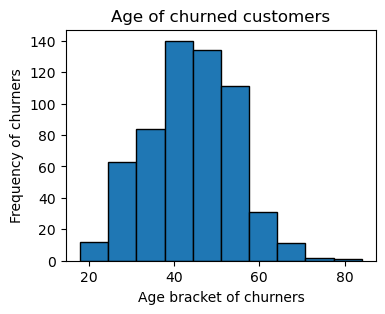

In [137]:
plt.figure(figsize=(4, 3))
plt.hist(df_1["age"], edgecolor="black")
plt.title("Age of churned customers")
plt.ylabel("Frequency of churners")
plt.xlabel("Age bracket of churners")

Text(0.5, 0, 'Age bracket of non-churners')

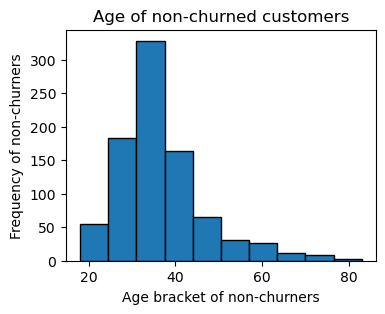

In [138]:
plt.figure(figsize=(4, 3))
plt.hist(df_0["age"], edgecolor="black")
plt.title("Age of non-churned customers")
plt.ylabel("Frequency of non-churners")
plt.xlabel("Age bracket of non-churners")

Alternatively, we can use seaborn to visualise both churners and non-churners in one graph. 

This will allow for better analysis as we can compare churners and non-churners more directly. I will use a count plot to do this.

(Note that the percentage code from line 7 to 12 is from Trenton McKinney on https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars)

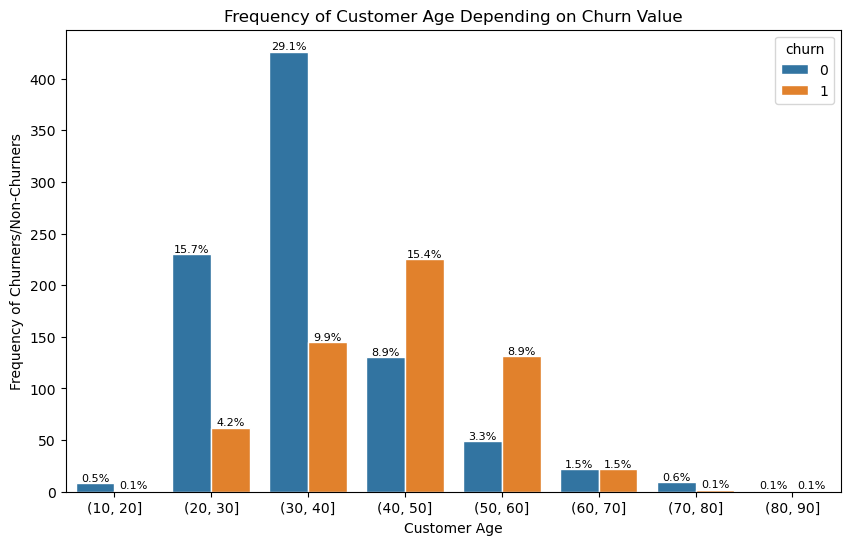

In [139]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="age_bracket", hue="churn", data=df, edgecolor="white")
plt.title("Frequency of Customer Age Depending on Churn Value")
plt.xlabel("Customer Age")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)

The ratio of churners to non-churners is differs in the age brackets.

- Customers aged (10,20], (20,30], (30,40] and (70,80] are less likely to churn.
- Customers aged (40,50] and (50,60] are more likely to churn.
- Customers aged (60,70] and (80,90] are equally likely to churn or not churn.

For future analysis, I will use this count plot. 

I believe it provides clearer information about churning by showing us the difference in frequency of churning in one graph.

Displaying separate diagrams with different y-value scales can mislead the reader into thinking churners and non-churners numbers are relatively equal as they have histograms of the same size. In reality. there are much more non-churners than churners, as shown in the merged plot.


Lastly, I would like to use a boxplot to check the spread of values of age for both churners and non-churners:

<Axes: xlabel='churn', ylabel='age'>

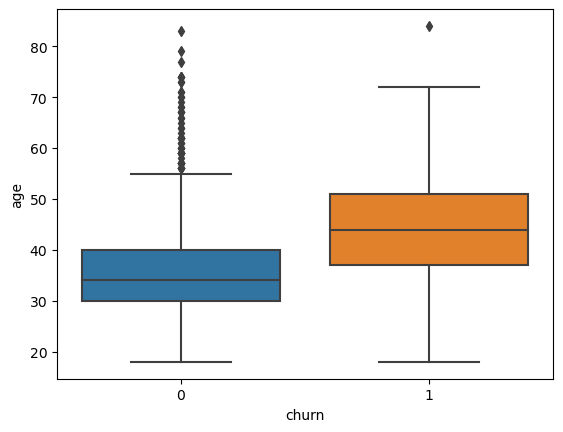

In [140]:
sns.boxplot(x="churn", y="age", data=df)

This shows us that churners tend to be older on average than non-churners, as we saw earlier.

The median and the upper quartile range are higher in churners than non-churners. The upper outlier for churners is also higher than non-churners'.

Additionally, there are much more non-churner outliers than churner outliers when it comes to age.

### Credit Score vs. Churn

In [141]:
pd.crosstab(df["credit_score_bracket"], df["churn"])

churn,0,1
credit_score_bracket,,
"(200, 300]",0,1
"(300, 400]",9,13
"(400, 500]",89,57
"(500, 600]",269,161
"(600, 700]",280,204
"(700, 800]",175,129
"(800, 900]",53,24


We can see that the most common credit scores are in the range (500,800], with most churners also in that range. 

If we plot this as a count plot we see:

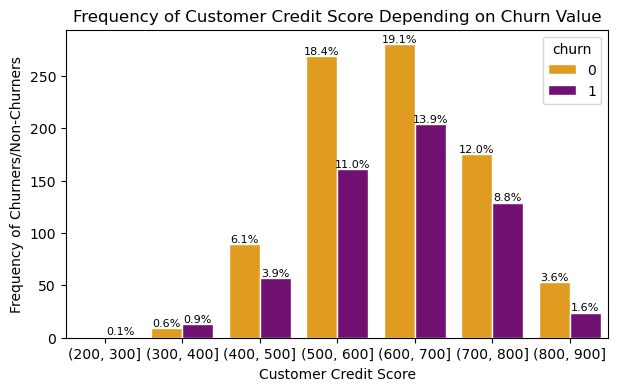

In [142]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="credit_score_bracket", hue="churn", data=df, edgecolor="white", palette=["orange", "purple"])
plt.title("Frequency of Customer Credit Score Depending on Churn Value")
plt.xlabel("Customer Credit Score")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)
    
#(Percentage code from Trenton McKinney on https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars)

For most credit score bracket (exceptions - (200,300] and (300,400]) there are much more non-churners than churners.

The highest churn rates (compared to non-churn rates) are in the brackets (600, 700], and (700,800]

The lowest churn rates (compared to non-churn rates) are in the brackets (500, 600].

We can represent this as a boxplot too:

<Axes: xlabel='churn', ylabel='credit_score'>

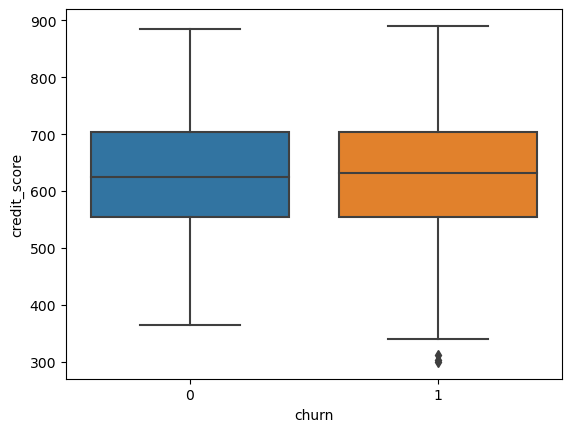

In [143]:
sns.boxplot(x="churn", y="credit_score", data=df)

We cann see that churners and non-churners are nearly identical when it comes to boxplots, showing that they tend to have the same range.

The minimum credit score of churners looks to be lower than non-churners, and there are even some outliers present in churners.

### Membership Length vs. Churn

In [144]:
pd.crosstab(df["membership_length_bracket"], df["churn"])

churn,0,1
membership_length_bracket,,
"(0.999, 30.0]",297,208
"(30.0, 60.0]",231,150
"(60.0, 90.0]",214,135
"(90.0, 120.0]",127,85
"(120.0, 150.0]",6,11


Visualising this we get:

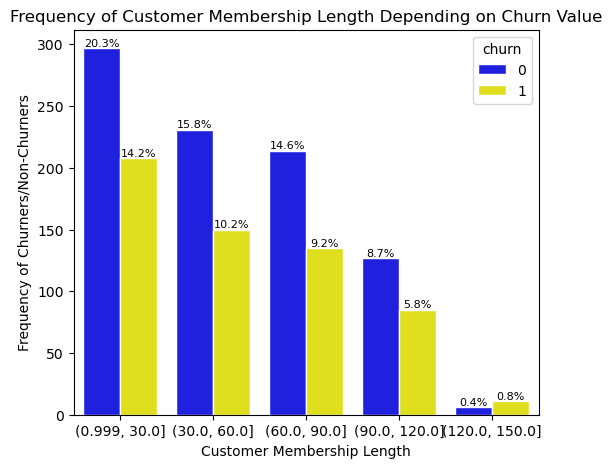

In [145]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(x="membership_length_bracket", hue="churn", data=df, edgecolor="white", palette=["blue", "yellow"])
plt.title("Frequency of Customer Membership Length Depending on Churn Value")
plt.xlabel("Customer Membership Length")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)
    
#(Percentage code from Trenton McKinney on https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars)

Once again, there are much less churners than non-churners.

The only bracket that doesn't follow this is (120, 150], with more churners than non-churners,but they account for about 1.2% of customers.

In most brackets, there is a ratio of 3:1 of non-churners to churners.

This trend suggests that customer membership length may not have a large impact on churning.

<Axes: xlabel='churn', ylabel='membership_length'>

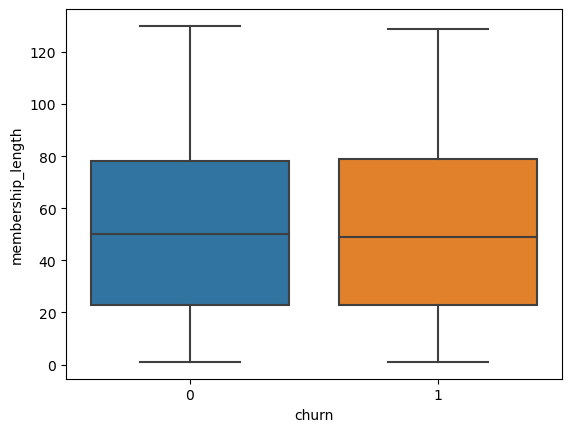

In [146]:
sns.boxplot(x="churn", y="membership_length", data=df)

Once again, membership length does not seem to have a large impact on churning when it comes to the spread/range of data.

### Balance vs. Churn

In [147]:
pd.crosstab(df["balance_bracket"], df["churn"])

churn,0,1
balance_bracket,,
"(-0.001, 300.0]",360,171
"(300.0, 600.0]",301,169
"(600.0, 900.0]",211,216
"(900.0, 1200.0]",3,30
"(1200.0, 1500.0]",0,3


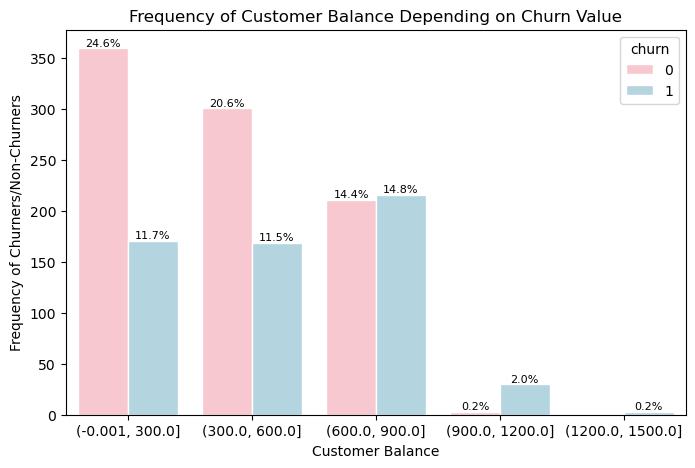

In [148]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="balance_bracket", hue="churn", data=df, edgecolor="white", palette=["pink", "lightblue"])
plt.title("Frequency of Customer Balance Depending on Churn Value")
plt.xlabel("Customer Balance")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)
    
#(Percentage code from Trenton McKinney on https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars)

We can see that the rate of churners increase as the balance increases:
- Only the lowest brackets [0, 300] and (300, 600] have more non-churners than churners.
- In (600, 900] there are slightly more churners than non-churners
- In (900, 1200] there are 10 times more churners than non-churners
- Every customer in the (1200, 1500] balance range is a churner.

This shows that balance seems to have an impact on churning. We will investigate this further later.

<Axes: xlabel='churn', ylabel='balance'>

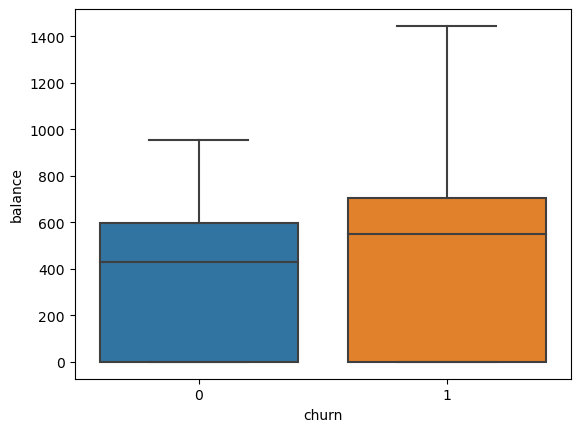

In [149]:
sns.boxplot(x="churn", y="balance", data=df)

Here we can see that churners tend to have slighly more balance than non-churners. 

The upper (75% percentile) range is also much higher for churners, with the max going over 1400, compared to non-churner's max of just under 1000, once again highlighting the fact that churners have more balance than non-churners.

### Number of Products vs. Churn

In [150]:
pd.crosstab(df["num_products"], df["churn"])

churn,0,1
num_products,,
1,441,435
2,432,88
3,2,50
4,0,16


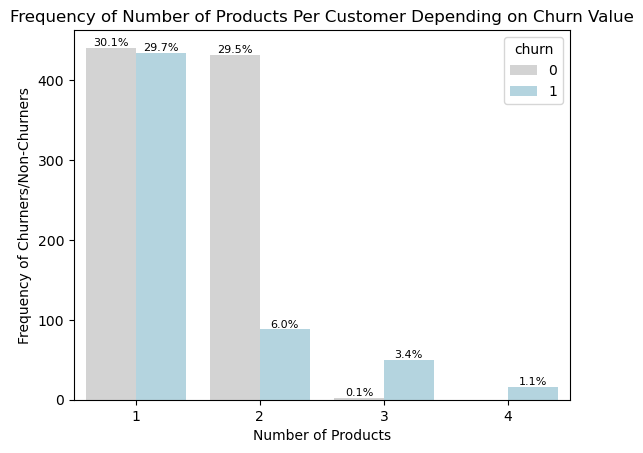

In [151]:
ax = sns.countplot(x="num_products", hue="churn", data=df, palette=["lightgrey", "lightblue"])
plt.title("Frequency of Number of Products Per Customer Depending on Churn Value")
plt.xlabel("Number of Products")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

Customers with 3 or 4 products are majorly churners.

Most customers have 1 or 2 products

There are nearly as many churners as non-churners for customers with 1 product.

There are significantly more non-churners than churners for customers with 2 products.

Since the distribution of churning varies for each value, this feature may influence churning.

<Axes: xlabel='churn', ylabel='num_products'>

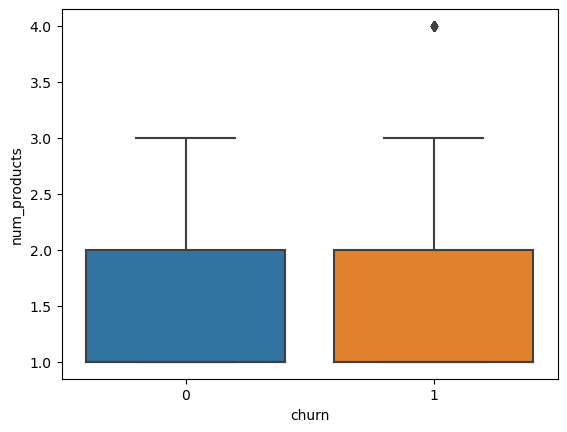

In [152]:
sns.boxplot(x="churn", y="num_products", data=df)

The boxplots look nearly identical, with the exception of an outlier for churners with 4 products.

### Number of Support Calls vs. Churn

In [153]:
pd.crosstab(df["num_support_calls"], df["churn"])

churn,0,1
num_support_calls,,
0,504,189
1,151,136
2,75,86
3,36,43
4,45,20
5,29,20
6,18,25
7,17,27
8,0,23


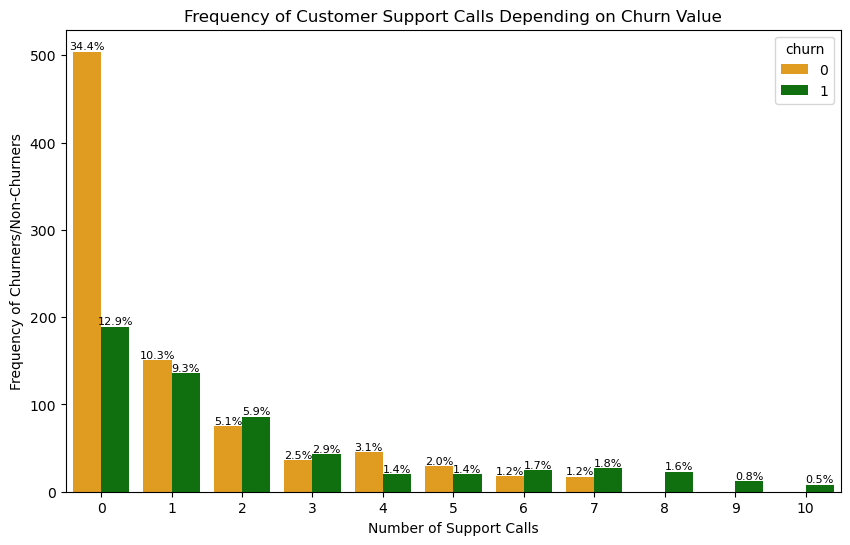

In [154]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="num_support_calls", hue="churn", data=df, palette=["orange", "green"])
plt.title("Frequency of Customer Support Calls Depending on Churn Value")
plt.xlabel("Number of Support Calls")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

Nearly 50% of the customer base have had no support calls, of which only 12.9% have churned. 

- For customers who have had 2, 3, 6, or 7 support calls, most have churned. 

- All customers with calls greater than 7 have churned. 

This is implies if a customer has had a large number of support calls, they may be very likely to churn. 

This makes sense. Such a customer is likely to have had a long unresolved problem with the products, which is likely to lead to customer dissatisfaction and churning.

<Axes: xlabel='churn', ylabel='num_support_calls'>

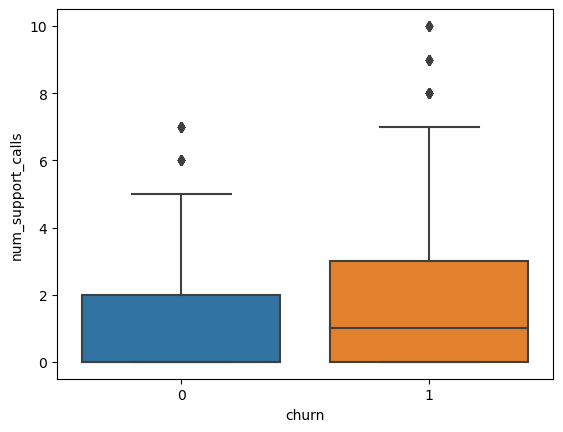

In [155]:
sns.boxplot(x="churn", y="num_support_calls", data=df)

The insights from the count plot are reflected in the boxplot as well, implying that churners have a higher number of support calls.

Both the median and the upper quartile range is higher in churners than in non-churners. There are more upper outliers as well.

## b) Analyse how “churn” relates to categorical features

Categorical features:
- location
- gender
- payment methods
- broadband bundle
- tv bundle

### Location vs Churn

In [156]:
pd.crosstab(df["location"], df["churn"])

churn,0,1
location,,
Connacht,202,116
Leinster,344,180
Munster,241,239
Ulster,88,54


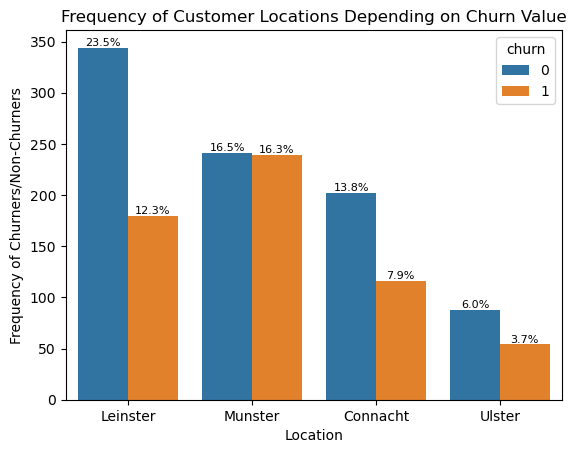

In [157]:
ax = sns.countplot(x="location", hue="churn", data=df)
plt.title("Frequency of Customer Locations Depending on Churn Value")
plt.xlabel("Location")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

Most churners are from Munster, while most non-churners are from Leinster. 

For every location except Munster, tthere are much more non-churners than non-churners(approximately twice as many.)

Munster has approximately as many churners as non-churners. 

Since the ratio of churning to not churning is similar for most values of location, location may not contribute to churning.

### Gender vs Churn

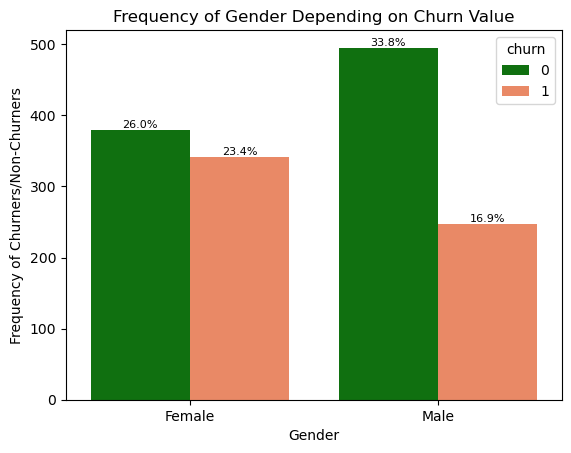

In [158]:
ax = sns.countplot(x="gender", hue="churn", data=df, palette=["green", "coral"])
plt.title("Frequency of Gender Depending on Churn Value")
plt.xlabel("Gender")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

From this graph, we can see that women tend to churn more often than men.

There are also much more non-churners who are men than non-churners who are women, even though there is approximately the same amount of women an men.

This difference suggests that customer gender may play a role in churning. 

In [159]:
churn["gender"].describe()

,count,unique,top,freq
churn,,,,
0,875,2,Male,495
1,589,2,Female,342


This table follows from the graph analysis.

### Payment Method vs Churn

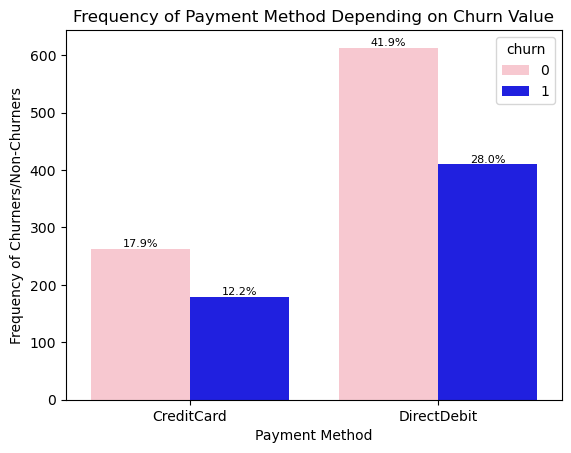

In [160]:
ax = sns.countplot(x="payment_method", hue="churn", data=df, palette=["pink", "blue"])
plt.title("Frequency of Payment Method Depending on Churn Value")
plt.xlabel("Payment Method")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

Most non-churners and churners are using direct debit. 

However, this does not imply that customers using debit are more likely to churn/not churn.

I will calculate the ratios of non-churners to churners to see if the rate of churning is different for the payment methods:

In [161]:
print("Percentage of CreditCard churners out of all CreditCard Customers: %.1f%%" % (((df[(df["payment_method"] == "CreditCard") & (df["churn"] == 1)].shape[0]) / (df[df["payment_method"] == "CreditCard"].shape[0])) * 100))
print("Percentage of CreditCard non-churners out of all CreditCard Customers: %.1f%%" % (((df[(df["payment_method"] == "CreditCard") & (df["churn"] == 0)].shape[0]) / (df[df["payment_method"] == "CreditCard"].shape[0])) * 100))
print("Percentage of DirectDebit churners out of all DirectDebit Customers: %.1f%%" % (((df[(df["payment_method"] == "DirectDebit") & (df["churn"] == 1)].shape[0]) / (df[df["payment_method"] == "DirectDebit"].shape[0])) * 100))
print("Percentage of DirectDebit non-churners out of all DirectDebit Customers: %.1f%%" % (((df[(df["payment_method"] == "DirectDebit") & (df["churn"] == 0)].shape[0]) / (df[df["payment_method"] == "DirectDebit"].shape[0])) * 100))

Percentage of CreditCard churners out of all CreditCard Customers: 40.6%
Percentage of CreditCard non-churners out of all CreditCard Customers: 59.4%
Percentage of DirectDebit churners out of all DirectDebit Customers: 40.1%
Percentage of DirectDebit non-churners out of all DirectDebit Customers: 59.9%


So, we can see that the ratios of churning/not churning is more or less the same for both creditcard and directdebit, suggesting that payment method does not influence churning.

### Broadband Bundle vs Churn

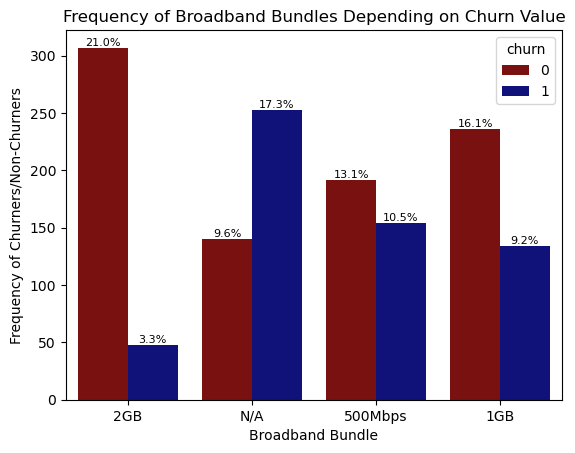

In [162]:
ax = sns.countplot(x="broadband_bundle", hue="churn", data=df, palette=["darkred", "darkblue"])
plt.title("Frequency of Broadband Bundles Depending on Churn Value")
plt.xlabel("Broadband Bundle")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

Most customers with the 2GB bundle are non-churners. (About 10% of these customers are churners, compared to ~90% non-churners)

Both 500Mbps and 1GB have more non-churners than churners as well, but there is a bigger percentage of churners than in 2GB. (More than a third of these customers are churners, compared to ~66% non-churners)

Surprisingly, the majority of customers without a broadband bundle are churners (approximately ~66% are churners)

Churning ratio is different for most values of broadband bundles, suggesting that this feature may have an effect on churning.

### Tv Bundle vs Churn

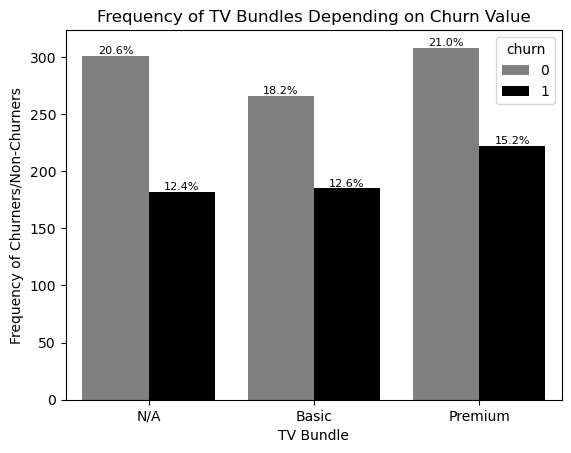

In [164]:
ax = sns.countplot(x="tv_bundle", hue="churn", data=df, palette=["grey", "black"])
plt.title("Frequency of TV Bundles Depending on Churn Value")
plt.xlabel("TV Bundle")
plt.ylabel("Frequency of Churners/Non-Churners")

for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df["churn"].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=8) 

All TV Bundle values seem to follow the same trend, with more non-churners than churners.

The uniformity implies this feature may not contribute to churning.

## c) Suggest which features contribute to churning



Based on our analysis from Task 2 (a) and (b), the features that have contributed most to churning are:

- Number of support calls
- Age
- Balance
- Has Broadband
- Gender

Location and number of products may contribute to churning as well but we cannot say for sure. This is because the data was similar for most attribute values, but not all. 

In terms of location location, only Munster showed different ratios of churning to non-churning compared to the other locations.

In terms the number of products, only higher number of products showed different ratios of churning to non-churning, but they were very rare occurrences and could be interpreted as outliers, so the evidence is not very strong.

Later on, during the modelling process, we can actually test if these features contribute to churning by training the model on different subsets of the data.

### Correlation

I would also like to check the correlation values of each variable against churning in order to calculate the relationship between churning and each feature

Note: We can only do this with numeric variables.

In [165]:
df_c = df.corr(numeric_only=True)

In [166]:
# we could turn this into a sorted DataFrame to show us a ranking for the pairs of variables
# with the highest and lowest correlation
from itertools import combinations
rows = []
for v1, v2 in combinations(df_c.columns, 2):
    rows.append({"Variable 1": v1, "Variable 2": v2, "Correlation": df_c[v1][v2]})
# show the ranked list
pd.DataFrame(rows).sort_values(by="Correlation", ascending=False)

,Variable 1,Variable 2,Correlation
27,num_products,has_tv,0.519129
26,num_products,has_broadband,0.448165
7,age,churn,0.344197
35,num_support_calls,churn,0.254357
25,balance,churn,0.196119
6,age,num_support_calls,0.081512
2,age,balance,0.063804
24,balance,num_support_calls,0.044120
34,has_tv,churn,0.036504
12,credit_score,has_tv,0.033569


The most significant churn correlations are:
1) age	vs churn = 0.344197
2) num_support_calls vs churn = 0.254357
3) has_broadband vs churn = - 0.298261

These values are very close to 0, showing that there is only a weak relationship beween these features and churning. 

The data and evidence point to these features not contributing very much to churning, although they are the features with the strongest relationship we can find in the dataset.

# Task 3: Classification

## a) Build 2 binary classification models to differentiate between churners and non-churners.

Before we can build our classification models, we first have to make our data and target from our dataset.

Our target will be the churn feature - what we would like to predict.

Our data must be entirely numerical, so some preprocessing is needed.

In [556]:
target = df["churn"]

First, I will create a new dataframe for our data. 

It will be a copy of our current dataframe df, minus some features, such as our target feature churn, and the binned data (age_bracket, balance_bracket, etc)

In [557]:
data = df.drop(columns=["age_bracket", "credit_score_bracket", "membership_length_bracket","balance_bracket", "churn"]).copy()

In [558]:
data.columns

Index(['age', 'location', 'gender', 'credit_score', 'membership_length',
       'balance', 'payment_method', 'num_products', 'has_broadband', 'has_tv',
       'broadband_bundle', 'tv_bundle', 'num_support_calls'],
      dtype='object')

Now we must convert our categorical features to numerical values. I will do this using the function pd.get_dummies

In [559]:
data = pd.get_dummies(data)

In [591]:
data.head(5)

,age,credit_score,membership_length,balance,num_products,has_broadband,has_tv,num_support_calls,location_Connacht,location_Leinster,...,gender_Male,payment_method_CreditCard,payment_method_DirectDebit,broadband_bundle_1GB,broadband_bundle_2GB,broadband_bundle_500Mbps,broadband_bundle_N/A,tv_bundle_Basic,tv_bundle_N/A,tv_bundle_Premium
customer_id,,,,,,,,,,,,,,,,,,,,,
71167,38.0,577,24,668.02,1,True,False,2,0,1,...,0,1,0,0,1,0,0,0,1,0
38777,27.0,698,52,531.28,1,False,True,0,0,0,...,0,1,0,0,0,0,1,1,0,0
76011,35.0,739,25,0.00,1,True,False,1,1,0,...,1,0,1,0,1,0,0,0,1,0
62859,38.0,628,39,530.97,1,True,False,0,0,1,...,1,0,1,0,1,0,0,0,1,0
53782,29.0,557,49,561.10,2,True,True,1,0,0,...,0,0,1,0,0,1,0,1,0,0


Our data is in the correct form for modelling now. 

So, I wil split the data into 70% training data and 30% testing data. 

(After some trial and error, I have found that this is the best ratio for maximum accuracy.)

In [741]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.3, random_state=1)

#Using dummy values produces an error with predicting the model. The error is resolved when the data and target are converted to numpy arrays.
train_data = train_data.values
test_data = test_data.values
train_target = train_target.values
test_target = test_target.values

In [713]:
print("Training set has %d examples" % train_data.shape[0])
print("Test set has %d examples" % test_data.shape[0])

Training set has 1024 examples
Test set has 440 examples


Now we can fit the model with our training data and target.

Afterwards, the model can predict the target value given some test data.

I am going to create 2 classification models - a K-Nearest Neighbor classifier model and a Decision Tree classifier model.

### K-Nearest Neighbor classifier model
Currently, we do not know the best value for k. I will recreate the K Nearest Neighbors model with different values of k to see which one is the most ideal, and then compare the best one with the decision tree model.

In [714]:
#Train K-Nearest Neighbor classifier from k = 1 to k = 30

#Average accuracy of eack k value
mean_accuracies = {}

for k in range(1, 31):
    #Apply KNN for current k
    knn = KNeighborsClassifier(n_neighbors=k)
    #Calculate mean accuracy across 5 folds
    fold_scores = cross_val_score(knn, test_data, test_target, cv=5, scoring="accuracy")
    mean_accuracies[k] = fold_scores.mean()

(1.0, 30.0)

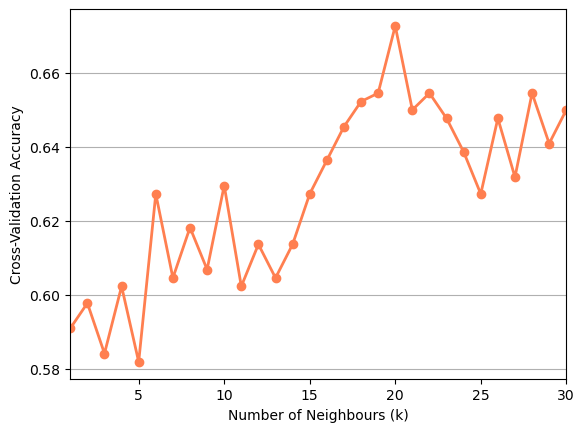

In [715]:
#Generate plot of all ks
df_mean_accuracies = pd.Series(mean_accuracies)
ax = df_mean_accuracies.plot(lw=2, marker="o", color="coral")
ax.set_ylabel("Cross-Validation Accuracy")
ax.set_xlabel("Number of Neighbours (k)")
ax.yaxis.grid()
ax.set_xlim(1, 30)

In [716]:
bestk = df_mean_accuracies.sort_values(ascending=False).index[0]
print("The best value for k = %d." % bestk)

The best value for k = 20.


In [717]:
#Train K-Nearest Neighbor classifier with best value
knn = KNeighborsClassifier(n_neighbors=bestk)
knn_model = knn.fit(train_data, train_target)

#Make predictions for test set
knn_predicted = knn.predict(test_data)

## Decision Tree

In [742]:
#Train classifier
dt = DecisionTreeClassifier()
md = dt.fit(train_data, train_target)

In [743]:
#Make predictions for test set
dt_predicted = dt.predict(test_data)

## b) Compare the performance of the 2 classification models using an appropriate evaluation strategy.

I will compare the performance of the 2 classification models by evaluating their accuracy and f1 score, as well as using a confusion matrix to see where the model goes wrong.

In [744]:
#Evaluate accuracy and F1 score of both models to compare
knn_accuracy = accuracy_score(test_target, knn_predicted)
dt_accuracy = accuracy_score(test_target, dt_predicted)
print("Accuracy of K-Nearest Neighbor Model at k=1: %.3f" % knn_accuracy)
print("Accuracy of Decision Tree Model: %.3f" % dt_accuracy)

print()

print("K-Nearest Neighbor Model F1(Churn) = %.3f" % f1_score(test_target, knn_predicted, pos_label=1))
print("K-Nearest Neighbor Model F1(Non-Churn) = %.3f" % f1_score(test_target, knn_predicted, pos_label=0))
print("Decision Tree Model F1(Churn) = %.3f" % f1_score(test_target, dt_predicted, pos_label=1))
print("Decision Tree Model F1(Non-Churn) = %.3f" % f1_score(test_target, dt_predicted, pos_label=0))

Accuracy of K-Nearest Neighbor Model at k=1: 0.664
Accuracy of Decision Tree Model: 0.734

K-Nearest Neighbor Model F1(Churn) = 0.408
K-Nearest Neighbor Model F1(Non-Churn) = 0.765
Decision Tree Model F1(Churn) = 0.657
Decision Tree Model F1(Non-Churn) = 0.783


Text(0.5, 1.0, 'Confusion Matrix of K-Nearest Neighbor Model')

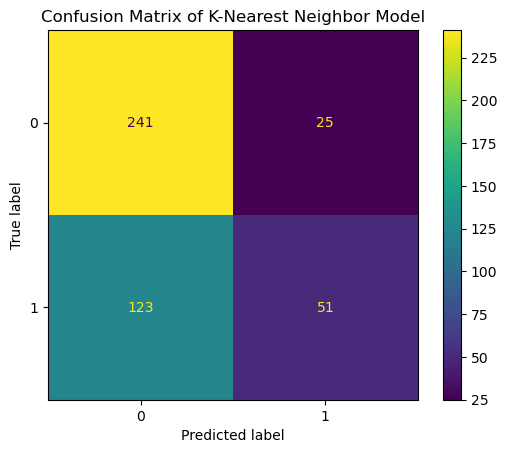

In [745]:
knn_cm = confusion_matrix(test_target, knn_predicted)
ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=knn.classes_).plot()
plt.title("Confusion Matrix of K-Nearest Neighbor Model")

Text(0.5, 1.0, 'Confusion Matrix of Decision Tree Model')

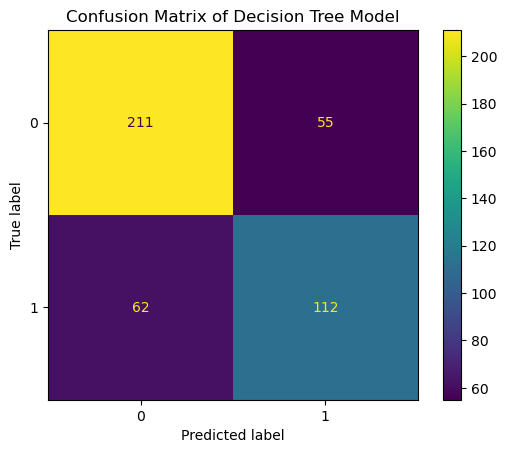

In [746]:
dt_cm = confusion_matrix(test_target, dt_predicted)
ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=dt.classes_).plot()
plt.title("Confusion Matrix of Decision Tree Model")

## Report and discuss the evaluation results

The decision tree model is more accurate than the K-Nearest neighbors model, even with the best k value. 

The KNN model correctly classified churners and non-churners 66.4% of the time, compared to the DT model's ~73.4%.

F1 score is useful in determining the accuracy of the model here as the number of non-churners in our dataset is much greater than the number of churners. 

In both models, the F1 score is higher for non-churning, meaning the models predict non-churning better. The models have similar non-churning F1 scores, with the decision tree model being slightly more accurate. 

However, the decision tree model is much better at predicting churning than the KNN model. In fact, it is KNN's lack of accuracy in predicting churning that makes it worse overall than the decision tree model.

The decision tree model has a better balance in predicting both churning and non-churning.

#### KNN Confusion Matrix

Of the ~175 customers that churned (lower two boxes), the model predicted ~50 of them to churn. (predicted correctly)

Of the ~265 customers that did not churn (upper two boxes), the model predicted ~240 of them to not churn. (predicted correctly)

Therefore, this model is very good at predicting non-churning, but rather poor at predicting churning.

#### Decision Tree Confusion Matrix

Of the ~175 customers that churned (lower two boxes), the model predicted ~110 of them to churn. (predicted correctly)

Of the ~265 customers that did not churn (upper two boxes), the model predicted ~210 of them to not churn. (predicted correctly)

Therefore, this model is very good at predicting churning, and good at predicting non-churning.

#### Direct Comparison

The KNN model predicts non-churning more accurately (~240 correct predictions/true negatives compared to DT's ~210).

The DT model predicts churning much more accurately (~110 correct predictions/true positives compared to KNN's ~50)

## c) Experiment with applying the same classifiers in combination with different subsets of descriptive features.

I have creates 8 subsets of the descriptive features below:

#### fullset 
Contains the entire set of features

#### subsetWithoutNA 
Contains the entire set of features, excluding "N/A" columns for TV Bundles and Broadband Bundles.

#### subsetWithBestFeatures
Contains the features we predicted to contribute the most to churning from Task 2.

#### subsetNumerical
Contains the numerical features only

#### subsetCategorical
Contains the categorical features only

#### subsetBundles
Contains the TV and Broadband bundles only

#### subsetWithPossibleBestFeatures
Contains the "best" features, as well as location, and number of products. We were unsure if these extra features contributed to churning, so we'll see if they result in more accurate models.

In [772]:
fullset = ['age', 'credit_score', 'membership_length', 'balance', 'num_products',
       'has_broadband', 'has_tv', 'num_support_calls', 'location_Connacht',
       'location_Leinster', 'location_Munster', 'location_Ulster',
       'gender_Female', 'gender_Male', 'payment_method_CreditCard',
       'payment_method_DirectDebit', 'broadband_bundle_1GB',
       'broadband_bundle_2GB', 'broadband_bundle_500Mbps',
       'broadband_bundle_N/A', 'tv_bundle_Basic', 'tv_bundle_N/A',
       'tv_bundle_Premium']

subsetWithoutNA = ['age', 'credit_score', 'membership_length', 'balance', 'num_products',
       'has_broadband', 'has_tv', 'num_support_calls', 'location_Connacht',
       'location_Leinster', 'location_Munster', 'location_Ulster',
       'gender_Female', 'gender_Male', 'payment_method_CreditCard',
       'payment_method_DirectDebit', 'broadband_bundle_1GB',
       'broadband_bundle_2GB', 'broadband_bundle_500Mbps', 'tv_bundle_Basic',
       'tv_bundle_Premium']

subsetWithBestFeatures = ['age', 'balance',
       'has_broadband', 'num_support_calls', 'gender_Female', 'gender_Male']

subsetNumerical = ['age', 'credit_score', 'membership_length', 'balance', 'num_products',
       'num_support_calls']

subsetCategorical = [
       'has_broadband', 'has_tv', 'location_Connacht',
       'location_Leinster', 'location_Munster', 'location_Ulster',
       'gender_Female', 'gender_Male', 'payment_method_CreditCard',
       'payment_method_DirectDebit', 'broadband_bundle_1GB',
       'broadband_bundle_2GB', 'broadband_bundle_500Mbps',
       'broadband_bundle_N/A', 'tv_bundle_Basic', 'tv_bundle_N/A',
       'tv_bundle_Premium']

subsetBundles = ['broadband_bundle_1GB',
       'broadband_bundle_2GB', 'broadband_bundle_500Mbps',
       'broadband_bundle_N/A', 'tv_bundle_Basic', 'tv_bundle_N/A',
       'tv_bundle_Premium']

subsetWithPossibleBestFeatures = ['age', 'balance', 'num_products',
       'has_broadband', 'num_support_calls', 'location_Connacht',
       'location_Leinster', 'location_Munster', 'location_Ulster',
       'gender_Female', 'gender_Male']

In [788]:
#Creating the list of subsets
dfs = []

dfs.append(data[fullset])
dfs.append(data[subsetWithoutNA])
dfs.append(data[subsetWithBestFeatures])
dfs.append(data[subsetNumerical])
dfs.append(data[subsetCategorical])
dfs.append(data[subsetBundles])
dfs.append(data[subsetWithPossibleBestFeatures])

In [789]:
#Testing KNN model on subsets
knn_model = KNeighborsClassifier(n_neighbors=bestk)
knn_scores = []
for dfsubsets in dfs:
    knn_scores.append((cross_val_score(knn_model, dfsubsets.values, target.values, cv=5, scoring="accuracy")).mean())

Text(0, 0.5, 'Average Accuracy')

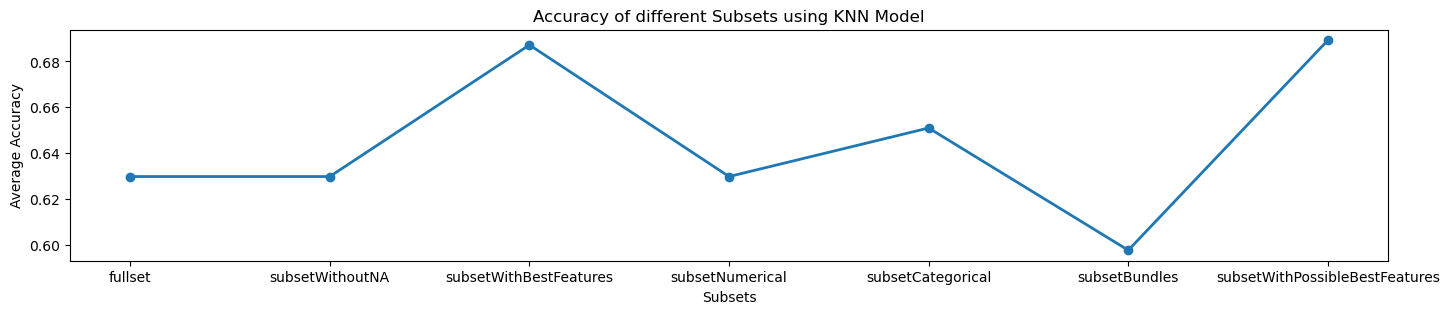

In [793]:
#Plotting mean accuracy of KNN models
subsets = ["fullset", "subsetWithoutNA", "subsetWithBestFeatures", "subsetNumerical", "subsetCategorical", "subsetBundles", "subsetWithPossibleBestFeatures"]
plt.figure(figsize=(17, 3))
plt.plot(subsets, knn_scores, marker="o", lw=2)
plt.title("Accuracy of different Subsets using KNN Model")
plt.xlabel("Subsets")
plt.ylabel("Average Accuracy")

In [791]:
bestscore = max(knn_scores)

for i in range(len(knn_scores)):
    if knn_scores[i] == bestscore:
        bestsubset = subsets[i]

In [792]:
print("Best subset: %s\nAccuracy: %.3f" % (bestsubset, bestscore))

Best subset: subsetWithPossibleBestFeatures
Accuracy: 0.689


In [778]:
#Testing Decision Tree Model on subsets
dt_scores = []
for dfsub in dfs:
    dt_scores.append((cross_val_score(dt_model, dfsub.values, target.values, cv=5, scoring="accuracy")).mean())

Text(0, 0.5, 'Average Accuracy')

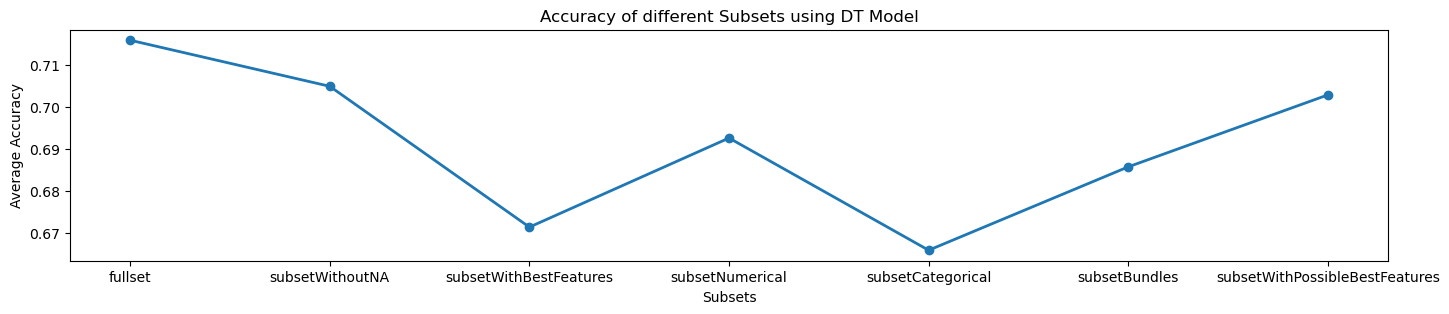

In [794]:
#Plotting mean accuracy of DT models
plt.figure(figsize=(17, 3))
plt.plot(subsets, dt_scores, marker="o", lw=2)
plt.title("Accuracy of different Subsets using DT Model")
plt.xlabel("Subsets")
plt.ylabel("Average Accuracy")

In [795]:
bestscore = max(dt_scores)

for i in range(len(dt_scores)):
    if dt_scores[i] == bestscore:
        bestsubset = subsets[i]

print("Best subset: %s\tAccuracy: %.3f" % (bestsubset, bestscore))

Best subset: fullset	Accuracy: 0.716


## Which feature(s) appear the most useful for classification?

We can order the subsets in terms of descending accuracy to see which subsets were the most accurate (and by extension useful)

In [796]:
dictsubsets = {}

for i in range(len(subsets)):
    dictsubsets[subsets[i]] = knn_scores[i]

In [797]:
ser = pd.Series(dictsubsets)

In [798]:
print("KNN Subsets and their accuracy in descending order")
ser.sort_values(ascending=False)

KNN Subsets and their accuracy in descending order


subsetWithPossibleBestFeatures    0.689228
subsetWithBestFeatures            0.687178
subsetCategorical                 0.650963
fullset                           0.629800
subsetWithoutNA                   0.629800
subsetNumerical                   0.629800
subsetBundles                     0.597679
dtype: float64

Unsurprisingly, the best and possible best features rank the highest.

In fact, all the features that we thought might contribute to churning were the most useful for the KNN model. 

Adding the features "location" and "number of products" slightly increased the accuracy of the model. 

We can also see here that pure categorical features performed better than the full set of features, suggesting that the numerical features were not very impactful on churning. We saw this earlier too when we calculated the correlation between churning and the numerical features, and found out that the relationships were rather weak.

In [803]:
dictsubsets = {}

for i in range(len(subsets)):
    dictsubsets[subsets[i]] = dt_scores[i]

In [800]:
ser = pd.Series(dictsubsets)

In [801]:
print("Decision Tree Subsets and their accuracy in descending order")

ser.sort_values(ascending=False)

Decision Tree Subsets and their accuracy in descending order


fullset                           0.715852
subsetWithoutNA                   0.704902
subsetWithPossibleBestFeatures    0.702866
subsetNumerical                   0.692620
subsetBundles                     0.685773
subsetWithBestFeatures            0.671453
subsetCategorical                 0.665964
dtype: float64

The fullset of features were most accurate here. This model was more accurate than KNN as well.

The best features surprisingly rank very low. They also perform worse than the best possible features, suggesting that the features "location" and "number of products" do truly contribute to churning.

The numerical features perform better here compared to the categorical features, unlike the KNN model.

#### Most useful features for KNN classification:

- age
- balance
- has_broadband
- num_support_calls
- gender
- location
- num_products

#### Most useful features for Decision Tree classification:

All features:
- age
- location
- gender
- credit_score
- membership_length
- balance
- payment_method
- num_products
- has_broadband
- has_tv
- broadband_bundle
- tv_bundle
- num_support_calls